# Classification of Fashion MNIST Dataset

In [1]:
# import reqired libraries
import os
import sys
import numpy as np
import struct

In [2]:
# Fetch data
LOCAL_PATH = "datasets/fashion"

In [11]:
def load_data(path=LOCAL_PATH):
    train_img = os.path.join(path, 'train-images-idx3-ubyte')
    train_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    test_img = os.path.join(path, 't10k-images-idx3-ubyte')
    test_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    
    # Load as numpy arrays
    with open(train_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        y_train = np.fromfile(flbl, dtype=np.int8)
        
    with open(test_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        y_test = np.fromfile(flbl, dtype=np.int8)
        
    with open(train_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        X_train = np.fromfile(fimg, dtype=np.int8).reshape(len(y_train), rows, cols)
        
    with open(test_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        X_test = np.fromfile(fimg, dtype=np.int8).reshape(len(y_test), rows, cols)
        
    return X_train, y_train, X_test, y_test

In [12]:
X_train, y_train, X_test, y_test = load_data()

In [15]:
print("Train data...")
print("num_samples: ",X_train.shape[0])
print("Image size: ", (X_train.shape[1], X_train.shape[2]))
print("Teast data...")
print("num_samples: ",X_test.shape[0])
print("Image size: ", (X_test.shape[1], X_test.shape[2]))

Train data...
num_samples:  60000
Image size:  (28, 28)
Teast data...
num_samples:  10000
Image size:  (28, 28)


In [19]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker",
         "Bag", "Ankle Boot"]

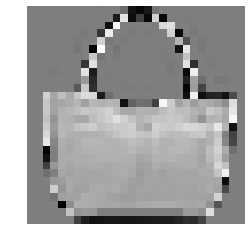

label:  Bag


In [20]:
# Lets visualize..
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_sample_img = X_train[100]
plt.imshow(some_sample_img, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print("label: ", labels[y_train[100]])

In [22]:
# Let's reshape the image as one long vector
X_train = X_train.reshape(-1, 784)
X_test = X_train.reshape(-1, 784)
print("Train_img:", X_train.shape)
print("Train_lbl:", y_train.shape)
print("Test_img:", y_train.shape)
print("Test_lbl:", y_test.shape)

Train_img: (60000, 784)
Train_lbl: (60000,)
Test_img: (60000,)
Test_lbl: (10000,)


In [23]:
# Shuffle the training data
np.random.seed(42) 
shuffle_idx = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

## Binary Classifier
Let's build a binary classifier to identify bags

In [58]:
y_train_bag = (y_train==8) #has to be in this form. y_train[y_train==8] does not work!!
y_test_bag = (y_test==8)

# Using Stochastic Gradient Descent Classifier:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, tol=1e-3)
sgd_clf.fit(X_train, y_train_bag)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
some_sample_image = X_train[4]
sgd_clf.predict(X_train[4:5])

array([ True])

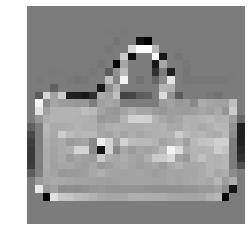

In [60]:
# plot to check
some_sample_image = some_sample_image.reshape(28,28)
plt.imshow(some_sample_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

### Let's use Cross validation to check how well this classifier performs.
Before that, let's try to use stratified samplig to ensure that the bag class is evenly distributed amog the k-folds

In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_bag):
    clone_clf = clone(sgd_clf) #Clone the classifier across diff folds
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))
    

0.51825
0.5274
0.5207
